In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

In [10]:
# === Config ===
IMG_SIZE = 75
CHAR_IMG_SIZE = 28
BATCH_SIZE = 64
EPOCHS = 50
CSV_PATH = 'D:\\1stop AI Internship May to June 2025\\Intenship Project - Object Detection (Kaggle dataset)\\Handwritten characters dataset\\image_labels.csv'

# === Load CSV ===
df = pd.read_csv(CSV_PATH)
image_root_dir = os.path.dirname(CSV_PATH)

images, labels, bboxes = [], [], []

# === Label Encoding ===
unique_labels = sorted(df['label'].unique())
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}
df['label_id'] = df['label'].map(label_to_id)

# === Compute Normalized Bounding Box ===
def compute_bbox(x, y, size=CHAR_IMG_SIZE):
    return [x / IMG_SIZE, y / IMG_SIZE, (x + size) / IMG_SIZE, (y + size) / IMG_SIZE]

# === Image Preprocessing ===
for _, row in df.iterrows():
    img_path = os.path.join(image_root_dir, row['filename'])
    if not os.path.exists(img_path): continue

    try:
        img = Image.open(img_path).convert('L').resize((CHAR_IMG_SIZE, CHAR_IMG_SIZE))
        bg = Image.new('L', (IMG_SIZE, IMG_SIZE), 255)
        x = np.random.randint(0, IMG_SIZE - CHAR_IMG_SIZE)
        y = np.random.randint(0, IMG_SIZE - CHAR_IMG_SIZE)
        bg.paste(img, (x, y))

        images.append(np.array(bg))
        labels.append(int(row['label_id']))
        bboxes.append(compute_bbox(x, y))
    except:
        continue

images = np.array(images).astype('float32') / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes).astype('float32')

num_classes = len(unique_labels)
labels_onehot = tf.keras.utils.to_categorical(labels, num_classes)


In [11]:
# Checking if they have the same value
print(len(images))
print(len(labels))
print(len(bboxes))

13640
13640
13640


In [12]:
# === Train/Test Split ===
X_train, X_val, y_train_cls, y_val_cls, y_train_bb, y_val_bb = train_test_split(
    images, labels_onehot, bboxes, test_size=0.2, random_state=42
)

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# === Classification Model ===
def build_classification_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# === Bounding Box Model ===
def build_bbox_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(4, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)


In [13]:
# === Train Classification ===
clf_model = build_classification_model()
clf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_clf = clf_model.fit(X_train, y_train_cls, validation_data=(X_val, y_val_cls), epochs=EPOCHS, batch_size=BATCH_SIZE)

# === Train Bounding Box ===
bbox_model = build_bbox_model()
bbox_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
hist_bbox = bbox_model.fit(X_train, y_train_bb, validation_data=(X_val, y_val_bb), epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.0175 - loss: 4.1244 - val_accuracy: 0.0572 - val_loss: 3.9709
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.0574 - loss: 3.8155 - val_accuracy: 0.0953 - val_loss: 3.4925
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.1336 - loss: 3.3712 - val_accuracy: 0.1723 - val_loss: 3.1197
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.2168 - loss: 3.0219 - val_accuracy: 0.2474 - val_loss: 2.8153
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.2808 - loss: 2.7161 - val_accuracy: 0.3288 - val_loss: 2.4648
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.3478 - loss: 2.4061 - val_accuracy: 0.3996 - val_loss: 2.1815
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.4086 - loss: 2.1364 - val_accuracy: 0.4490 - val_loss: 1.9795
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.4517 - loss: 1.9611

In [14]:
# === Evaluate Classification Model ===
loss_cls, acc_cls = clf_model.evaluate(X_val, y_val_cls, verbose=0)
print(f"Classification Model - Loss: {loss_cls:.4f}, Accuracy: {acc_cls:.4f}")

# === Evaluate Bounding Box Model ===
loss_bb, mse_bb = bbox_model.evaluate(X_val, y_val_bb, verbose=0)
print(f"Bounding Box Model - Loss: {loss_bb:.4f}, MSE: {mse_bb:.4f}")


Classification Model - Loss: 0.7177, Accuracy: 0.7661
Bounding Box Model - Loss: 0.0184, MSE: 0.0184


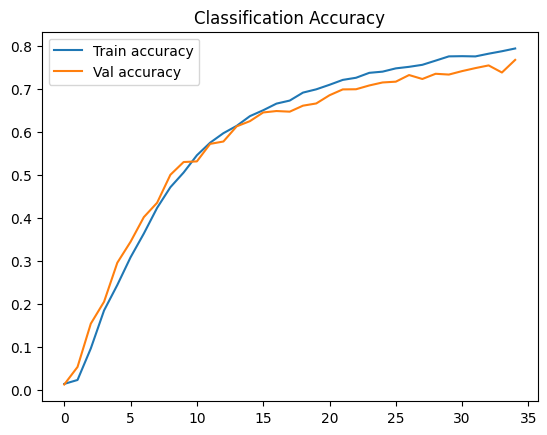

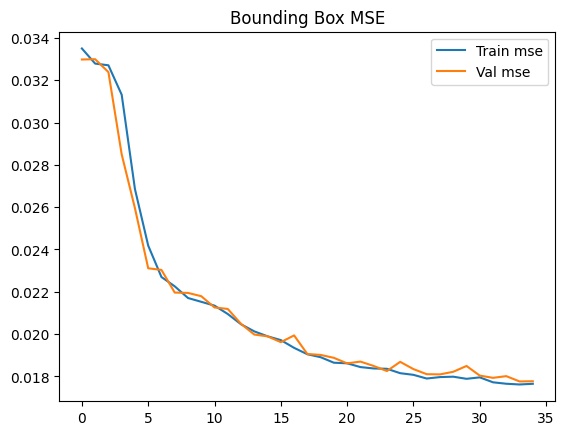

In [22]:
def plot_metrics(history, metric, title):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history['val_' + metric], label=f'Val {metric}')
    plt.title(title)
    plt.legend()
    plt.show()

plot_metrics(hist_clf, 'accuracy', 'Classification Accuracy')
plot_metrics(hist_bbox, 'mse', 'Bounding Box MSE')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


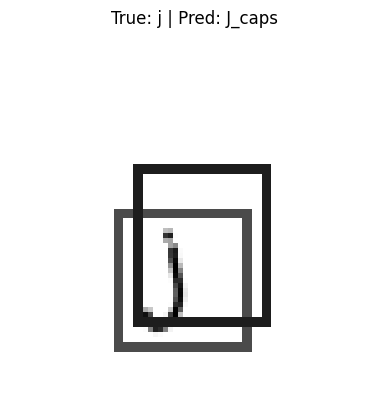

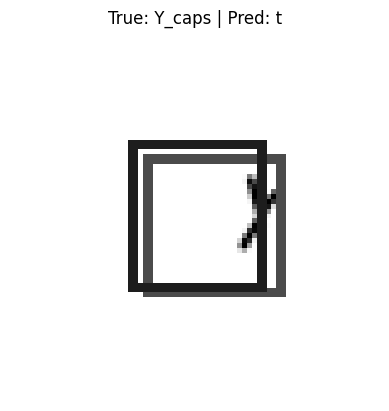

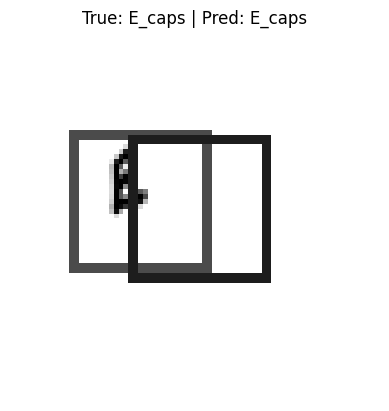

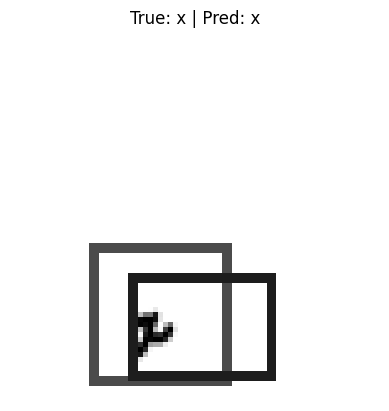

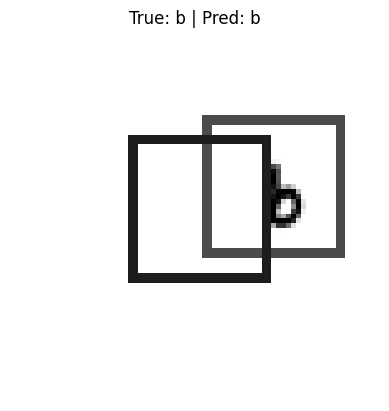

In [15]:
# === Select 5 validation samples
n = 5
sample_imgs = X_val[:n]
sample_cls_true = y_val_cls[:n]
sample_bb_true = y_val_bb[:n]

# === Get predictions
cls_preds = clf_model.predict(sample_imgs)
bb_preds = bbox_model.predict(sample_imgs)

for i in range(n):
    img = Image.fromarray((sample_imgs[i].squeeze() * 255).astype(np.uint8))
    draw = ImageDraw.Draw(img)

    # Actual bounding box (green)
    true_bb = sample_bb_true[i]
    draw.rectangle(
        [true_bb[0]*IMG_SIZE, true_bb[1]*IMG_SIZE, true_bb[2]*IMG_SIZE, true_bb[3]*IMG_SIZE],
        outline='green', width=2
    )

    # Predicted bounding box (blue)
    pred_bb = bb_preds[i]
    draw.rectangle(
        [pred_bb[0]*IMG_SIZE, pred_bb[1]*IMG_SIZE, pred_bb[2]*IMG_SIZE, pred_bb[3]*IMG_SIZE],
        outline='blue', width=2
    )

    # Actual & predicted label
    true_label = id_to_label[np.argmax(sample_cls_true[i])]
    pred_label = id_to_label[np.argmax(cls_preds[i])]

    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()


In [ ]:
# Execute these lines to save the neural network model for future use
# The will be saved in the current working directory

# Save classification model
clf_model.save('classification_model.h5')

# Save bounding box model
bbox_model.save('bbox_model.h5')
